In [66]:
from __future__ import division
import os

import matplotlib.pyplot as plt
import pandas as pd


pd.options.mode.chained_assignment = None

work_dir = os.environ['WORK_DIR']
df = pd.read_csv(os.path.join(work_dir, 'movie_metadata.csv'))
df.head()


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [67]:
missing = df[df.isnull().any(axis=1)].count().to_frame()
missing.columns = ['missing']
total = df.count().to_frame()
total.columns = ['total']

share_of_missing = missing.join(total)
share_of_missing.share = share_of_missing.missing / share_of_missing.total

                missing  total
content_rating      984   4740
title_year         1179   4935
['PG-13' 'PG' 'G' 'R' 'TV-14' 'Not Rated' 'Unrated' 'Approved' 'NC-17' 'X'
 'GP' 'Passed' 'M' 'TV-G' 'TV-PG']
title_year
1916            [Not Rated]
1925            [Not Rated]
1927            [Not Rated]
1929    [Not Rated, Passed]
1930               [Passed]
1932              [Unrated]
1933    [Unrated, Approved]
1934              [Unrated]
1935             [Approved]
1936          [G, Approved]
Name: content_rating, dtype: object
title_year
2007                   [PG-13, PG, G, R, TV-G, Not Rated]
2008                [PG-13, PG, G, R, Not Rated, Unrated]
2009                [PG-13, PG, R, G, Not Rated, Unrated]
2010    [PG, PG-13, G, R, Not Rated, Unrated, TV-14, T...
2011    [PG-13, G, PG, R, Not Rated, NC-17, TV-PG, Unr...
2012                   [PG-13, PG, R, G, Not Rated, TV-G]
2013         [PG-13, G, PG, R, Not Rated, Unrated, TV-14]
2014                [PG-13, PG, G, R, Not Rated, Unra

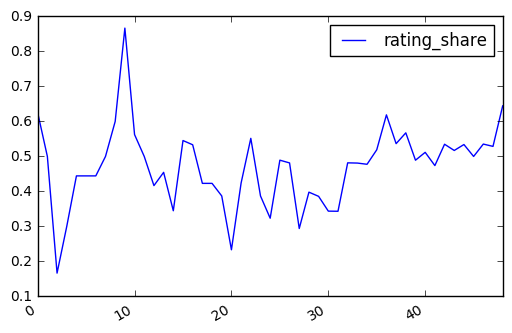

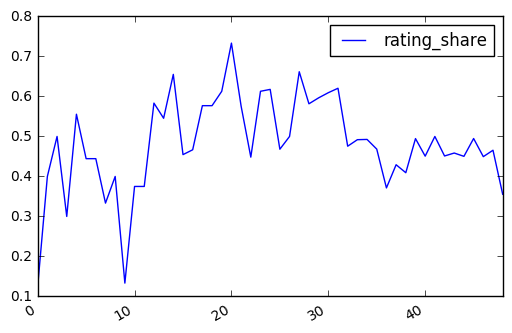

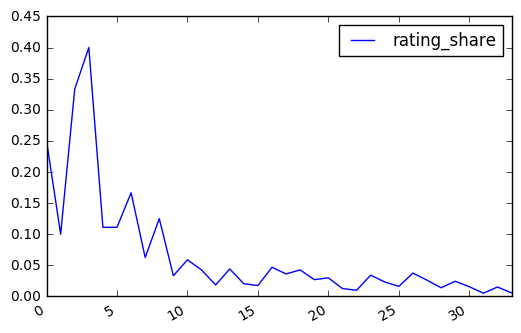

In [71]:
# ratings time series

labels = ['content_rating', 'title_year']
print share_of_missing.loc[labels]

ts = df[labels]
ts = ts[pd.notnull(ts.title_year) & pd.notnull(ts.content_rating)]
ts.title_year = ts.title_year.astype(int)

print ts.content_rating.unique()

ratings = ts[labels].groupby('title_year')['content_rating'].unique()
print ratings.head(10)
print ratings.tail(10)
# https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system
ts = ts[ts.title_year >= 1968]

def map_ratings(row):
    immaculate = ['G', 'TV-G']
    decent = ['PG', 'GP', 'PG-13', 'M']
    foul = ['R', 'NC-17', 'X']
    
    if row.content_rating in immaculate:
        return 'immaculate'
    if row.content_rating in decent:
        return 'decent'
    if row.content_rating in foul:
        return 'foul'

ts['rating_map'] = ts.apply(map_ratings, axis=1)
ts = ts.groupby(['title_year', 'rating_map']).count().reset_index()
ts['yearly_total'] = ts.groupby('title_year')['content_rating'].transform('sum')
ts['rating_share'] = ts.content_rating / ts.yearly_total
ts.head()


ts.groupby('rating_map').plot(x='title_year', y='rating_share', subplots=True, use_index=False)
plt.show()